In [1]:
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
TRAIN_DIR = r'C:\Users\ASUS\Certan12\face2\data\train'
TEST_DIR = r'C:\Users\ASUS\Certan12\face2\data\test'

In [3]:
# Function to create a DataFrame of image paths and labels
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir, label)):
            image_paths.append(os.path.join(dir, label, imagename))
            labels.append(label)
        print(f"{label} completed")
    return image_paths, labels

In [4]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

.ipynb_checkpoints completed
marah completed
netral completed
sedih completed
senang completed
takut completed
.ipynb_checkpoints completed
marah completed
netral completed
sedih completed
senang completed
takut completed


In [5]:
from tqdm.notebook import tqdm

In [6]:
print(train)

                                                  image  label
0     C:\Users\ASUS\Certan12\face2\data\train\marah\...  marah
1     C:\Users\ASUS\Certan12\face2\data\train\marah\...  marah
2     C:\Users\ASUS\Certan12\face2\data\train\marah\...  marah
3     C:\Users\ASUS\Certan12\face2\data\train\marah\...  marah
4     C:\Users\ASUS\Certan12\face2\data\train\marah\...  marah
...                                                 ...    ...
6231  C:\Users\ASUS\Certan12\face2\data\train\takut\...  takut
6232  C:\Users\ASUS\Certan12\face2\data\train\takut\...  takut
6233  C:\Users\ASUS\Certan12\face2\data\train\takut\...  takut
6234  C:\Users\ASUS\Certan12\face2\data\train\takut\...  takut
6235  C:\Users\ASUS\Certan12\face2\data\train\takut\...  takut

[6236 rows x 2 columns]


In [7]:
print(test.head())

                                               image  label
0  C:\Users\ASUS\Certan12\face2\data\test\marah\i...  marah
1  C:\Users\ASUS\Certan12\face2\data\test\marah\i...  marah
2  C:\Users\ASUS\Certan12\face2\data\test\marah\i...  marah
3  C:\Users\ASUS\Certan12\face2\data\test\marah\i...  marah
4  C:\Users\ASUS\Certan12\face2\data\test\marah\i...  marah


In [8]:
# Function to extract features (image preprocessing)
def extract_features(images):
    features = []
    for image in tqdm(images, desc="Processing Images"):
        try:
            # Load image as grayscale and resize to (48, 48)
            img = load_img(image, color_mode='grayscale', target_size=(48, 48))
            img = img_to_array(img)
            features.append(img)
        except Exception as e:
            print(f"Error loading image {image}: {e}")
    return np.array(features)

In [9]:
# Extract features and preprocess
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

Processing Images:   0%|          | 0/6236 [00:00<?, ?it/s]

Processing Images:   0%|          | 0/6236 [00:00<?, ?it/s]

In [10]:
# Convert labels to categorical (one-hot encoding)
train_labels = pd.Categorical(train['label']).codes
test_labels = pd.Categorical(test['label']).codes

In [11]:
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

In [12]:
# Normalize pixel values
train_features = train_features / 255.0
test_features = test_features / 255.0

In [13]:
# Reshape for CNN input (add channel dimension)
train_features = train_features.reshape(-1, 48, 48, 1)
test_features = test_features.reshape(-1, 48, 48, 1)

In [14]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_labels_cat, test_size=0.2, random_state=42
)

In [15]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Setup Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [17]:
# Calculate class weights for imbalanced data
y_train_classes = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weights = dict(enumerate(class_weights))

In [18]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Callback untuk Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validasi loss
    patience=10,            # Berhenti jika tidak ada peningkatan selama 10 epoch
    restore_best_weights=True,  # Kembalikan bobot terbaik
    min_delta=0.001         # Minimal perubahan yang dianggap signifikan
)

# Callback untuk menurunkan learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,             # Kurangi learning rate sebesar 80%
    patience=5,             # Jika tidak ada peningkatan selama 5 epoch
    min_lr=0.00001          # Learning rate minimum
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotasi gambar
    width_shift_range=0.2,  # Geser horizontal
    height_shift_range=0.2, # Geser vertikal
    shear_range=0.2,        # Transformasi geser
    zoom_range=0.2,         # Zooming
    horizontal_flip=True,   # Flip horizontal
    fill_mode='nearest'     # Isi area kosong
)

# Fit the generator to the training data
datagen.fit(X_train)

# Assuming y_train is already defined as the one-hot encoded labels
y_train_classes = np.argmax(y_train, axis=1)  # Convert one-hot encoded labels back to class indices

from sklearn.utils.class_weight import compute_class_weight

# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_classes), 
    y=y_train_classes
)
class_weights = dict(enumerate(class_weights))

# Continue with your data augmentation and model training...

In [19]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2199 - loss: 1.6078 - val_accuracy: 0.1955 - val_loss: 1.6106 - learning_rate: 3.0000e-04
Epoch 2/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1993 - loss: 1.6057 - val_accuracy: 0.1835 - val_loss: 1.6107 - learning_rate: 3.0000e-04
Epoch 3/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1928 - loss: 1.6069 - val_accuracy: 0.2252 - val_loss: 1.6034 - learning_rate: 3.0000e-04
Epoch 4/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2284 - loss: 1.6016 - val_accuracy: 0.2676 - val_loss: 1.5924 - learning_rate: 3.0000e-04
Epoch 5/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2639 - loss: 1.5816 - val_accuracy: 0.2877 - val_loss: 1.5776 - learning_rate: 3.0000e-04
Epoch 6/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2817 - loss: 1.5695 - val_accuracy: 0.2772 - val_loss: 1.5688 - learning_rate: 3.0000e-04
Epoch 7/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc

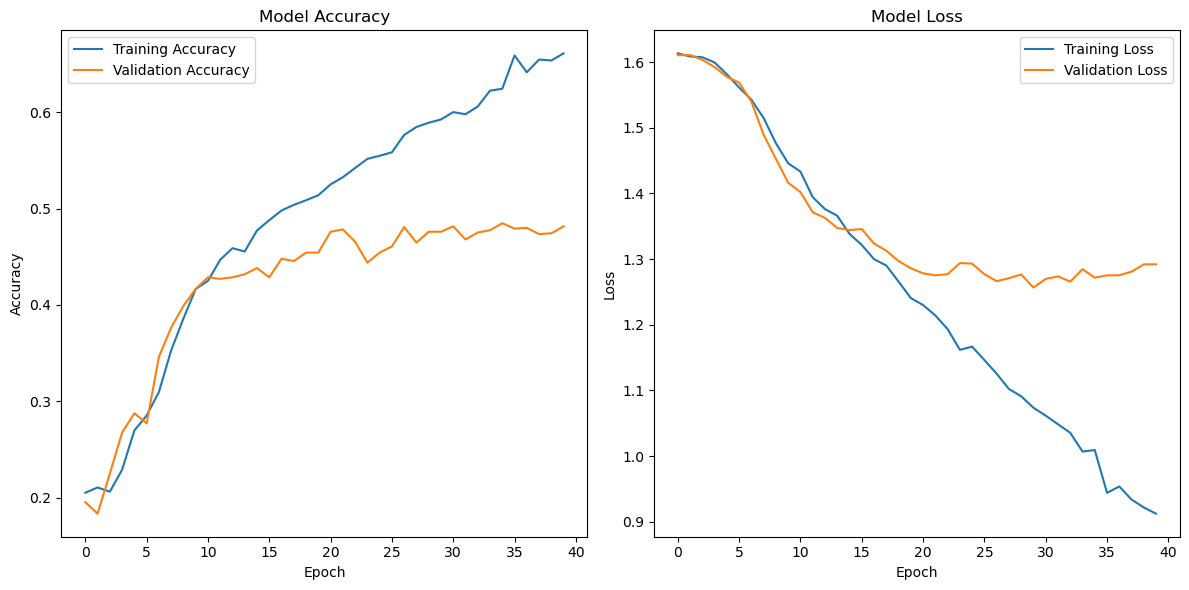

In [20]:
# Optional: Plot training history
import matplotlib.pyplot as plt

# Plot Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

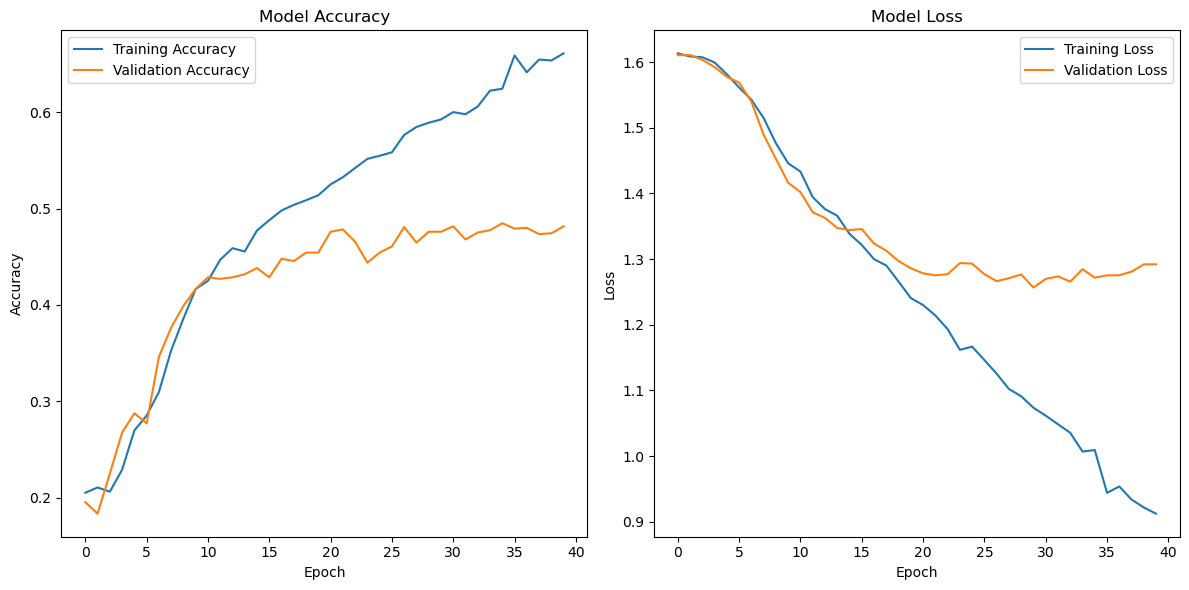

In [21]:
# Optional: Plot training history
import matplotlib.pyplot as plt

# Plot Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_features, test_labels_cat)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6462 - loss: 0.9951   
Test Accuracy: 65.64%


In [23]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_features, test_labels_cat)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save('best_model2.keras')

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6462 - loss: 0.9951 
Test Accuracy: 65.64%


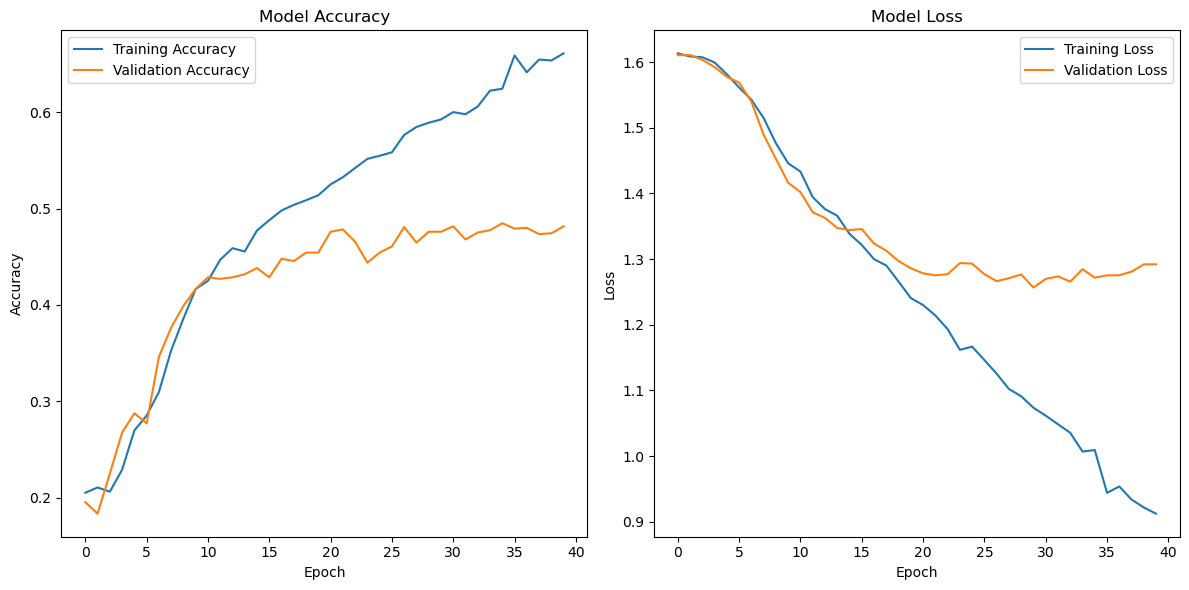

In [24]:
# Optional: Plot training history
import matplotlib.pyplot as plt

# Plot Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
import tensorflow as tf

image = r'C:\Users\ASUS\Certan12\Face_Recog_Model\data\test\angry\im15.png'
# Memuat gambar sebagai grayscale dan mengubah ukurannya
image = tf.keras.utils.load_img(image, color_mode='grayscale', target_size=(48, 48))

# Mengonversi gambar menjadi array
img_arr = tf.keras.utils.img_to_array(image)

# Menambahkan dimensi batch untuk prediksi
img_bat = tf.expand_dims(img_arr, 0)

# Melakukan prediksi
predict = model.predict(img_bat)
print(predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[1. 0. 0. 0. 0.]]


In [26]:
score = tf.nn.softmax(predict)

In [27]:
expression_names = ['angry', 'fearful', 'happy', 'neutral', 'sad']
print('Ekspresi in image is {} with accuracy of {:0.2f}'.format(expression_names[np.argmax(score)],np.max(score)*100))

Ekspresi in image is angry with accuracy of 40.46


195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


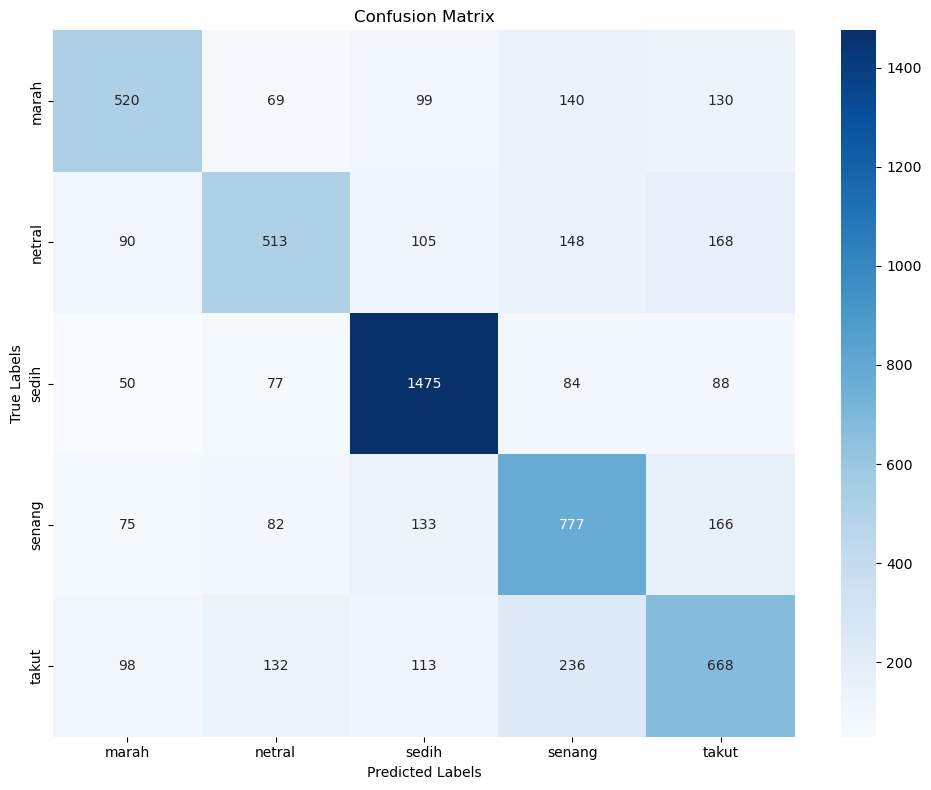


Detailed Classification Report:
              precision    recall  f1-score   support

       marah     0.6242    0.5428    0.5807       958
      netral     0.5876    0.5010    0.5409      1024
       sedih     0.7662    0.8315    0.7975      1774
      senang     0.5610    0.6302    0.5936      1233
       takut     0.5475    0.5357    0.5415      1247

    accuracy                         0.6339      6236
   macro avg     0.6173    0.6082    0.6108      6236
weighted avg     0.6308    0.6339    0.6306      6236



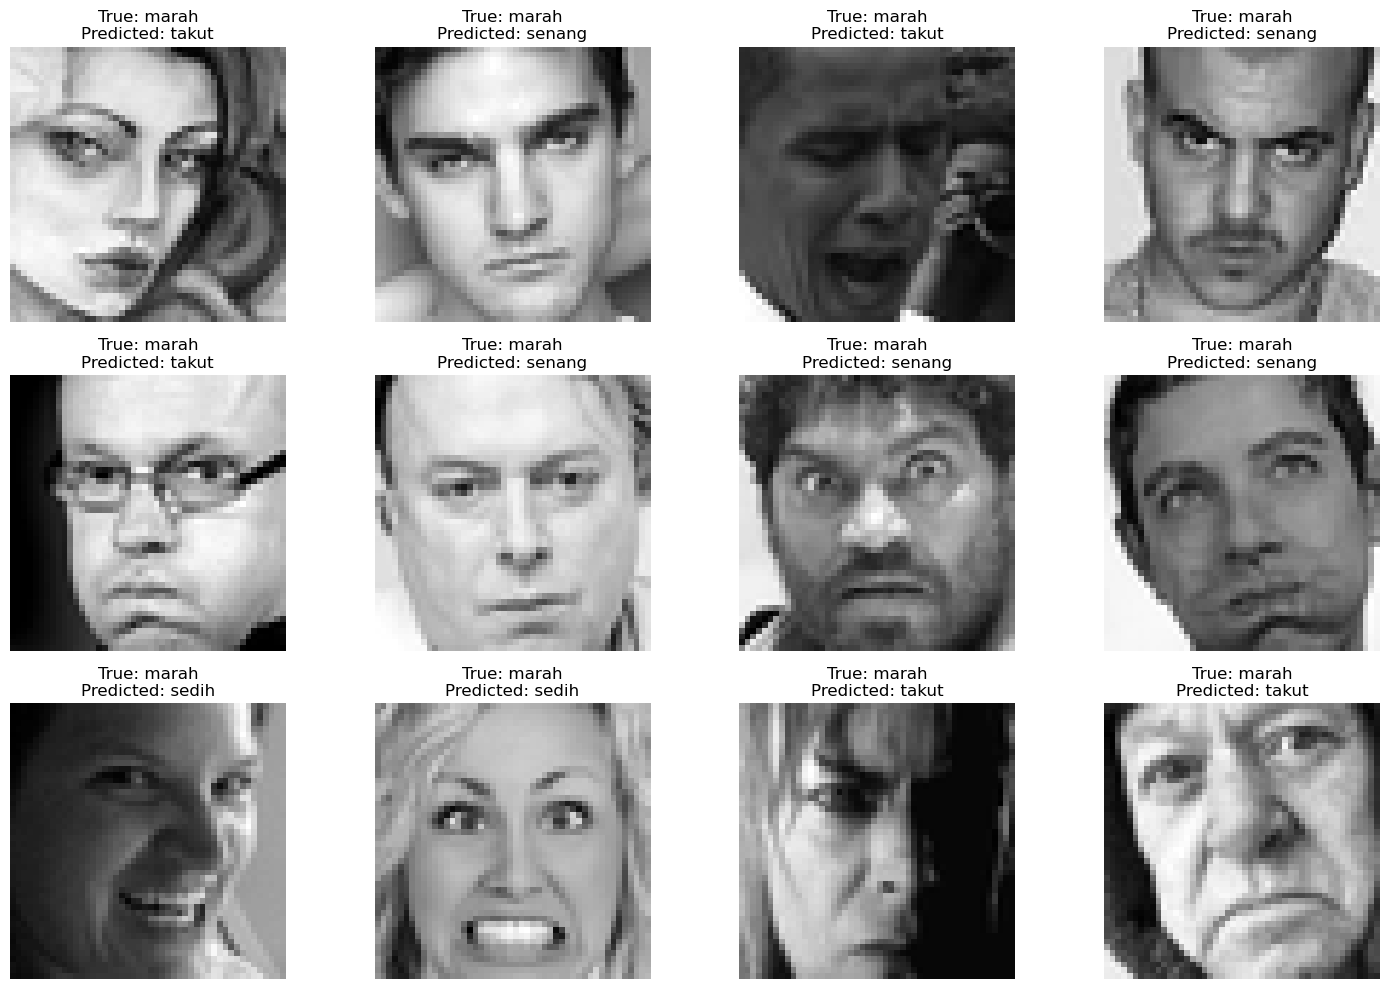


Overall Metrics:
Accuracy: 0.6339
Macro Precision: 0.6173
Macro Recall: 0.6082
Macro F1-Score: 0.6108
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

Error Analysis:
      index true_label predicted_label  true_label_prob  predicted_label_prob
0         1      marah           takut         0.175337              0.435994
1         2      marah          senang         0.345900              0.457656
2         4      marah           takut         0.247552              0.345542
3         6      marah          senang         0.330796              0.443086
4         9      marah           takut         0.282301              0.386511
...     ...        ...             ...              ...                   ...
2278   6229      takut          senang         0.232448              0.277214
2279   6231      takut           marah         0.042586              0.798334
2280   6232      takut           sedih         0.300404              0.334169
2281   6233      takut          netral         0.143360   

In [27]:
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# (Reuse your previous code for data preparation up to model training)

# After training the model and before saving, add these evaluation steps

# Predict on test data
y_pred = model.predict(test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels_cat, axis=1)

# Get class names (ensure this matches your original label order)
class_names = ['marah', 'netral', 'sedih', 'senang', 'takut']

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                            target_names=class_names, 
                            digits=4))

# Visualize Misclassifications
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

# Plot some misclassified images
plt.figure(figsize=(15,10))
for i, idx in enumerate(misclassified_indices[:12]):  # Show first 12 misclassifications
    plt.subplot(3, 4, i+1)
    plt.imshow(test_features[idx].reshape(48,48), cmap='gray')
    plt.title(f'True: {class_names[y_true_classes[idx]]}\n'
              f'Predicted: {class_names[y_pred_classes[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Additional Metrics Calculation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Macro average metrics
precision_macro = precision_score(y_true_classes, y_pred_classes, average='macro')
recall_macro = recall_score(y_true_classes, y_pred_classes, average='macro')
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")

# Per-class prediction probabilities
prediction_probabilities = model.predict(test_features)

# Create a detailed error analysis
error_analysis = []
for i, (true, pred, probs) in enumerate(zip(y_true_classes, y_pred_classes, prediction_probabilities)):
    if true != pred:
        error_analysis.append({
            'index': i,
            'true_label': class_names[true],
            'predicted_label': class_names[pred],
            'true_label_prob': probs[true],
            'predicted_label_prob': probs[pred]
        })

# Convert to DataFrame for easy analysis
error_df = pd.DataFrame(error_analysis)
print("\nError Analysis:")
print(error_df)

# Save error analysis to CSV
error_df.to_csv('misclassification_analysis.csv', index=False)

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


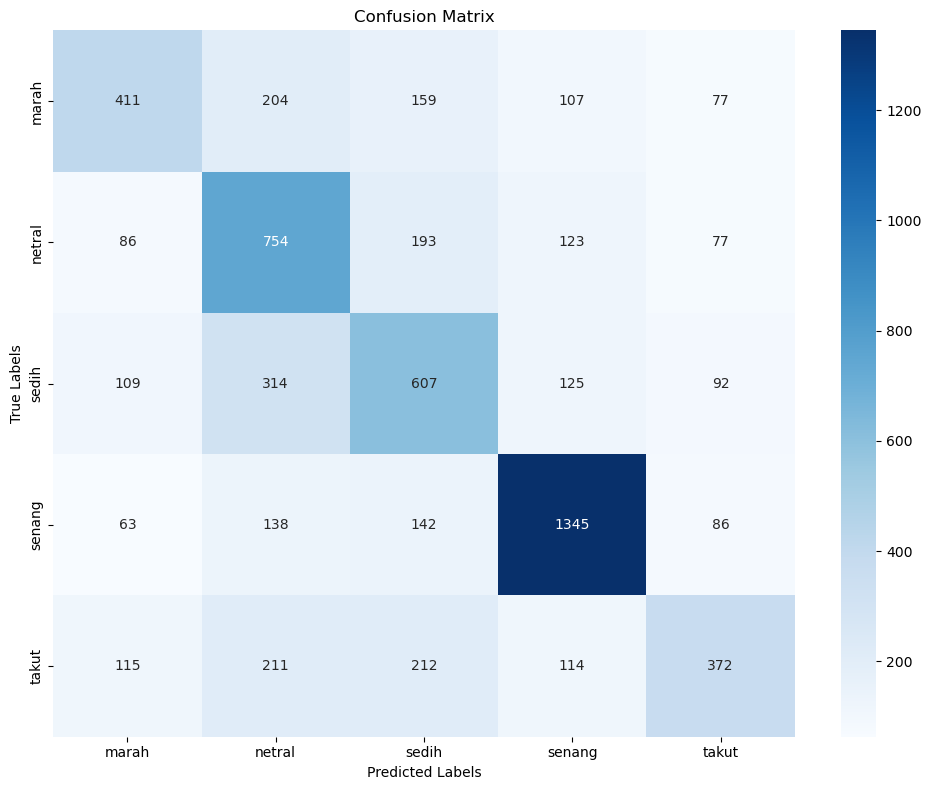


Detailed Classification Report:
              precision    recall  f1-score   support

       marah     0.5242    0.4290    0.4719       958
      netral     0.4651    0.6115    0.5284      1233
       sedih     0.4623    0.4868    0.4742      1247
      senang     0.7415    0.7582    0.7497      1774
       takut     0.5284    0.3633    0.4306      1024

    accuracy                         0.5595      6236
   macro avg     0.5443    0.5298    0.5309      6236
weighted avg     0.5626    0.5595    0.5558      6236



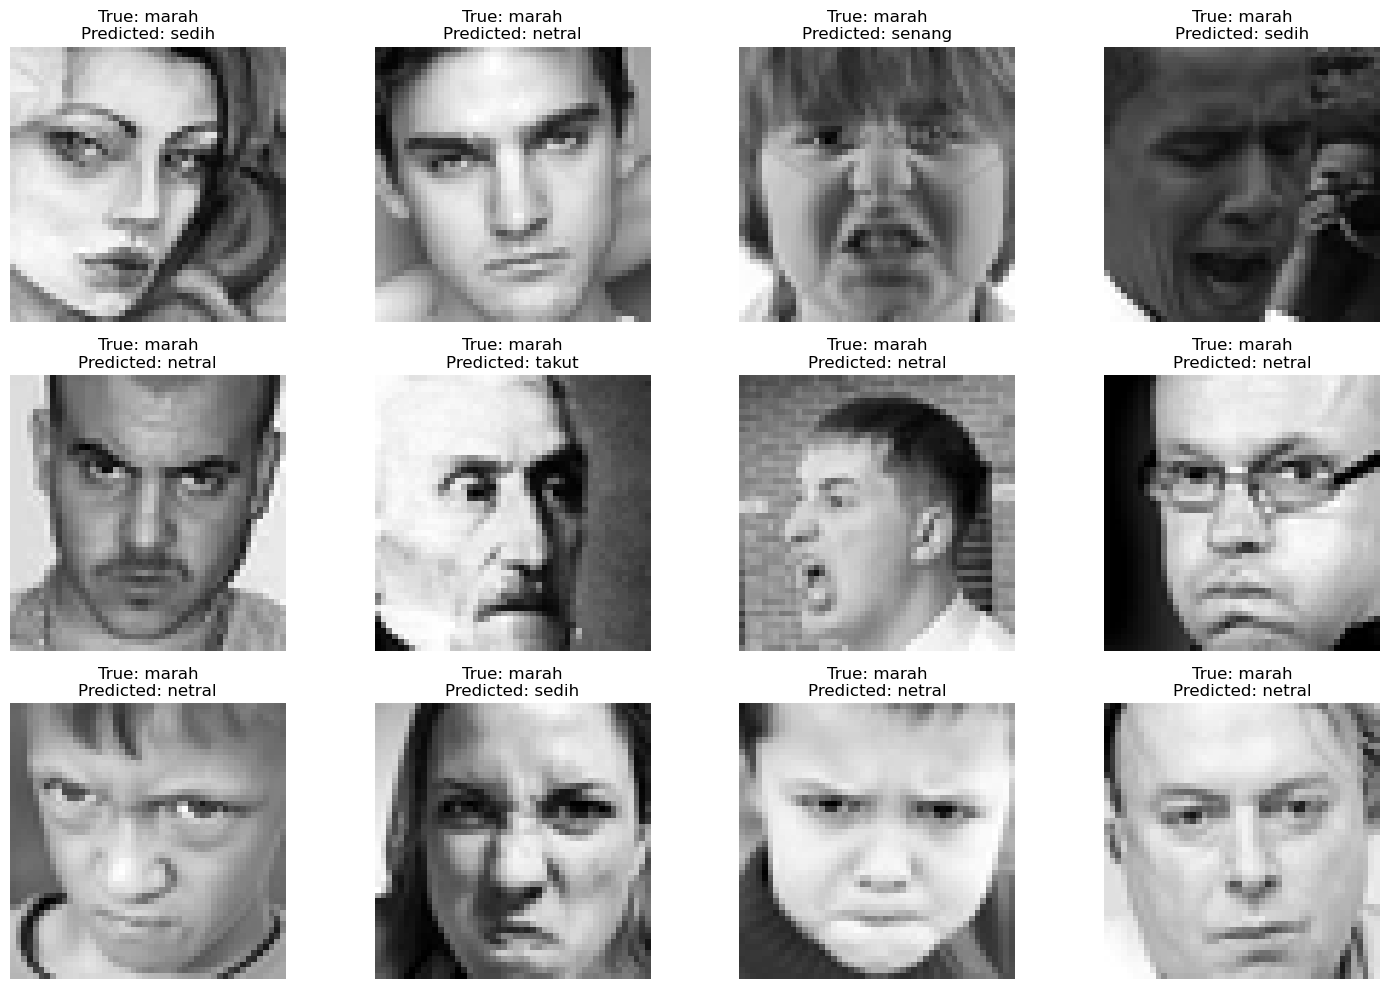


Overall Metrics:
Accuracy: 0.5595
Macro Precision: 0.5443
Macro Recall: 0.5298
Macro F1-Score: 0.5309
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Error Analysis:
      index true_label predicted_label  true_label_prob  predicted_label_prob
0         1      marah           sedih         0.199264              0.344538
1         2      marah          netral         0.303549              0.451120
2         3      marah          senang         0.238279              0.293179
3         4      marah           sedih         0.245194              0.327579
4         6      marah          netral         0.224015              0.438730
...     ...        ...             ...              ...                   ...
2742   6228      takut           sedih         0.164784              0.275788
2743   6231      takut          senang         0.037155              0.745895
2744   6232      takut          netral         0.262540              0.409874
2745   6233      takut           marah         0.273958    

In [53]:
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# (Reuse your previous code for data preparation up to model training)

# After training the model and before saving, add these evaluation steps

# Predict on test data
y_pred = model.predict(test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels_cat, axis=1)

# Get class names (ensure this matches your original label order)
class_names = ['marah', 'netral', 'sedih', 'senang', 'takut']

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                            target_names=class_names, 
                            digits=4))

# Visualize Misclassifications
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

# Plot some misclassified images
plt.figure(figsize=(15,10))
for i, idx in enumerate(misclassified_indices[:12]):  # Show first 12 misclassifications
    plt.subplot(3, 4, i+1)
    plt.imshow(test_features[idx].reshape(48,48), cmap='gray')
    plt.title(f'True: {class_names[y_true_classes[idx]]}\n'
              f'Predicted: {class_names[y_pred_classes[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Additional Metrics Calculation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Macro average metrics
precision_macro = precision_score(y_true_classes, y_pred_classes, average='macro')
recall_macro = recall_score(y_true_classes, y_pred_classes, average='macro')
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")

# Per-class prediction probabilities
prediction_probabilities = model.predict(test_features)

# Create a detailed error analysis
error_analysis = []
for i, (true, pred, probs) in enumerate(zip(y_true_classes, y_pred_classes, prediction_probabilities)):
    if true != pred:
        error_analysis.append({
            'index': i,
            'true_label': class_names[true],
            'predicted_label': class_names[pred],
            'true_label_prob': probs[true],
            'predicted_label_prob': probs[pred]
        })

# Convert to DataFrame for easy analysis
error_df = pd.DataFrame(error_analysis)
print("\nError Analysis:")
print(error_df)

# Save error analysis to CSV
error_df.to_csv('misclassification_analysis.csv', index=False)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
DATA_DIR = r'C:\Users\Lenovo\certan\data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)


# Load datasets
train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

val_dataset = image_dataset_from_directory(
    VAL_DIR,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    TEST_DIR,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

# Get class names
class_names = train_dataset.class_names

# Normalization
normalization_layer = Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu'),  # Tambah layer Conv2D dengan 256 filter
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(256, activation='relu'),  # Tambah Dense layer dengan unit lebih banyak
    Dropout(0.4),
    Dense(len(class_names), activation='softmax')
])


# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=80,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


Found 6236 files belonging to 5 classes.
Found 937 files belonging to 5 classes.
Found 6236 files belonging to 5 classes.
Epoch 1/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.2709 - loss: 1.6000 - val_accuracy: 0.2807 - val_loss: 1.5937 - learning_rate: 1.0000e-04
Epoch 2/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2830 - loss: 1.5909 - val_accuracy: 0.2807 - val_loss: 1.5932 - learning_rate: 1.0000e-04
Epoch 3/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2797 - loss: 1.5886 - val_accuracy: 0.2807 - val_loss: 1.5941 - learning_rate: 1.0000e-04
Epoch 4/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2815 - loss: 1.5870 - val_accuracy: 0.2818 - val_loss: 1.5921 - learning_rate: 1.0000e-04
Epoch 5/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2820 - loss: 1.5862 - val_accuracy: 0.2785 - val_loss: 1.5899 - learning_rate: 1.0000e-04
Epoch 6/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2829 - loss: 1.5816 - val_

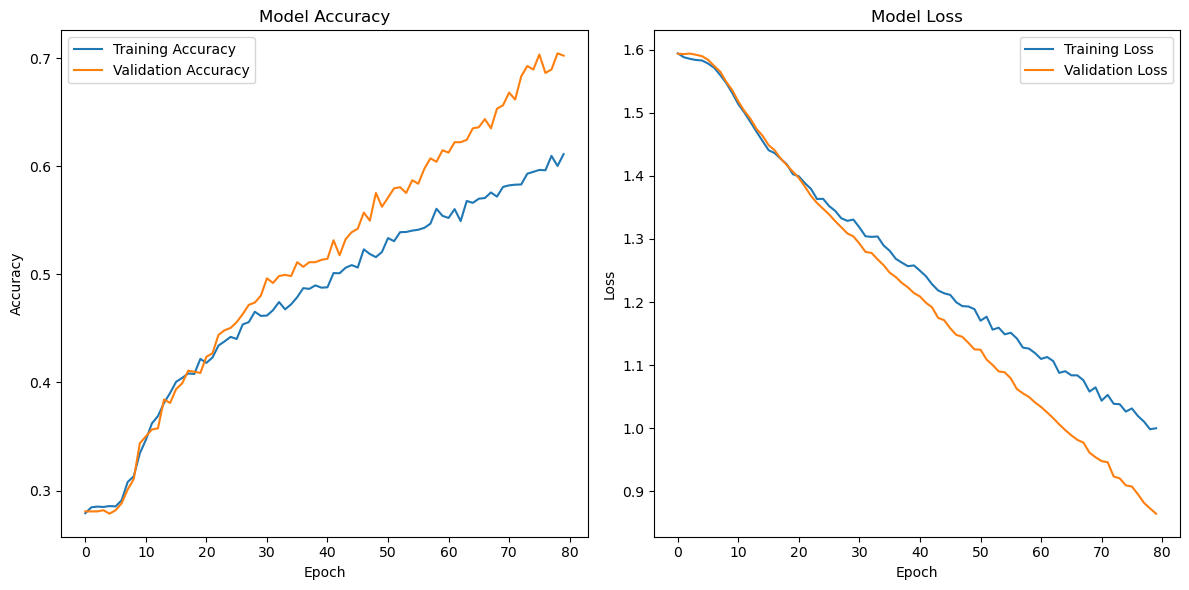

In [11]:
# Optional: Plot training history
import matplotlib.pyplot as plt

# Plot Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

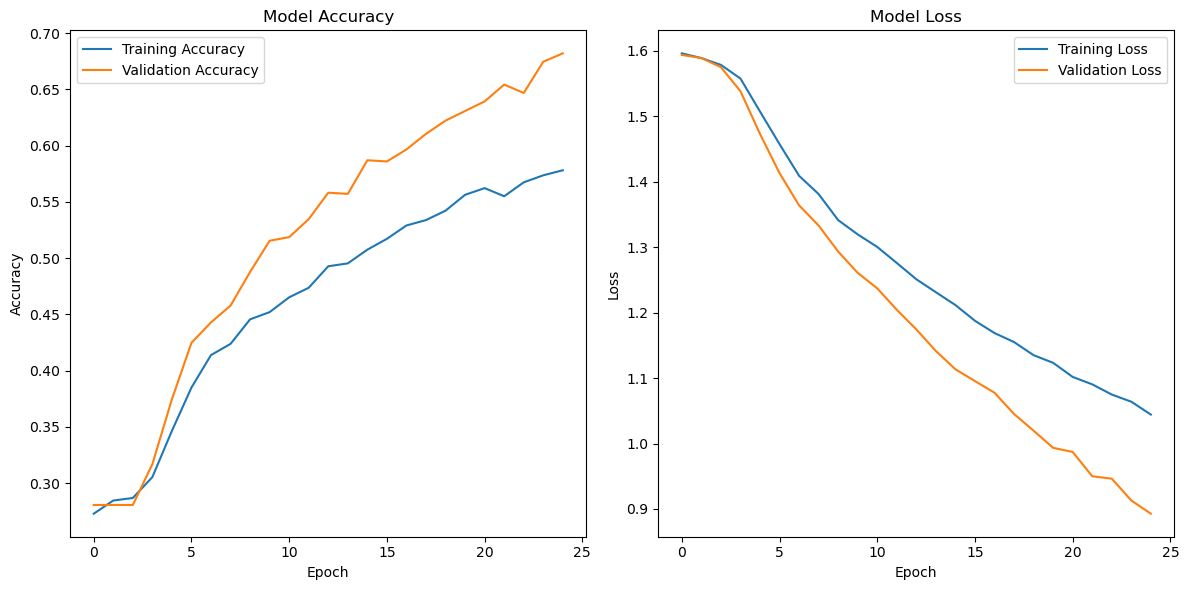

In [9]:
# Optional: Plot training history
import matplotlib.pyplot as plt

# Plot Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# Evaluate the model on test data using the generator
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save('best_model2.keras')


195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6960 - loss: 0.8511
Test Accuracy: 69.40%


195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


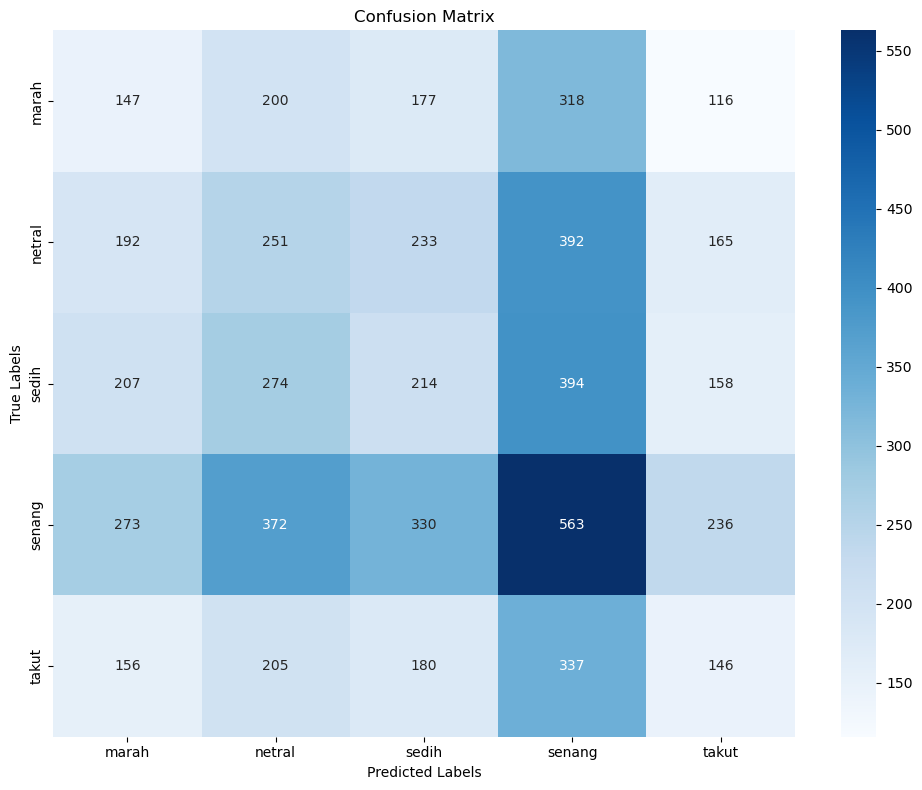


Detailed Classification Report:
              precision    recall  f1-score   support

       marah     0.1508    0.1534    0.1521       958
      netral     0.1928    0.2036    0.1980      1233
       sedih     0.1887    0.1716    0.1798      1247
      senang     0.2809    0.3174    0.2980      1774
       takut     0.1778    0.1426    0.1583      1024

    accuracy                         0.2118      6236
   macro avg     0.1982    0.1977    0.1972      6236
weighted avg     0.2081    0.2118    0.2092      6236


Overall Metrics:
Accuracy: 0.2118
Macro Precision: 0.1982
Macro Recall: 0.1977
Macro F1-Score: 0.1972


NameError: name 'test_features' is not defined

In [15]:
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# (Reuse your previous code for data preparation up to model training)

# After training the model and before saving, add these evaluation steps

# Extract true labels from test_dataset
y_true_classes = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)  # Convert to class indices

# Predict on test data
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names (ensure this matches your original label order)
class_names = ['marah', 'netral', 'sedih', 'senang', 'takut']

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                            target_names=class_names, 
                            digits=4))


# Additional Metrics Calculation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Macro average metrics
precision_macro = precision_score(y_true_classes, y_pred_classes, average='macro')
recall_macro = recall_score(y_true_classes, y_pred_classes, average='macro')
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")

# Per-class prediction probabilities
prediction_probabilities = model.predict(test_features)

# Create a detailed error analysis
error_analysis = []
for i, (true, pred, probs) in enumerate(zip(y_true_classes, y_pred_classes, prediction_probabilities)):
    if true != pred:
        error_analysis.append({
            'index': i,
            'true_label': class_names[true],
            'predicted_label': class_names[pred],
            'true_label_prob': probs[true],
            'predicted_label_prob': probs[pred]
        })

# Convert to DataFrame for easy analysis
error_df = pd.DataFrame(error_analysis)
print("\nError Analysis:")
print(error_df)

# Save error analysis to CSV
error_df.to_csv('misclassification_analysis.csv', index=False)

In [ ]:
#test ke 2

from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Rescaling, Lambda
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
import os

# Directories
DATA_DIR = r'C:\Users\Lenovo\certan\data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Load datasets
train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

val_dataset = image_dataset_from_directory(
    VAL_DIR,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    TEST_DIR,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

# Convert grayscale to RGB for VGG16 compatibility
train_dataset = train_dataset.map(lambda x, y: (Lambda(lambda z: tf.image.grayscale_to_rgb(z))(x), y))
val_dataset = val_dataset.map(lambda x, y: (Lambda(lambda z: tf.image.grayscale_to_rgb(z))(x), y))
test_dataset = test_dataset.map(lambda x, y: (Lambda(lambda z: tf.image.grayscale_to_rgb(z))(x), y))

# Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the model with transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=80,
    callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler]
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


Found 6236 files belonging to 5 classes.
Found 937 files belonging to 5 classes.
Found 6236 files belonging to 5 classes.
Epoch 1/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.2167 - loss: 18.9335 - val_accuracy: 0.2871 - val_loss: 6.4119 - learning_rate: 1.0000e-04
Epoch 2/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.2216 - loss: 13.2530 - val_accuracy: 0.3095 - val_loss: 4.9337 - learning_rate: 1.0000e-04
Epoch 3/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.2775 - loss: 9.6931 - val_accuracy: 0.3340 - val_loss: 3.8888 - learning_rate: 1.0000e-04
Epoch 4/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.2871 - loss: 7.3228 - val_accuracy: 0.3479 - val_loss: 3.2241 - learning_rate: 1.0000e-04
Epoch 5/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.3017 - loss: 5.7885 - val_accuracy: 0.3735 - val_loss: 2.7256 - learning_rate: 1.0000e-04
Epoch 6/80
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.3070 - loss: